In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

def create_trace(ts, tssig, omega, sigma):
    """Generate a trace using the sine and exponential functions."""
    return np.sin(2. * np.pi * (ts - tssig) * omega) * np.exp(-(ts - tssig)**2 / sigma)

def save_trace_to_csv(ts, trace, idat, directory):
    """Save the generated trace data to a CSV file."""
    df = pd.DataFrame({'Time': ts, 'Trace': trace})
    filename = os.path.join(directory, f'trace_data_{idat}.csv')
    df.to_csv(filename, index=False)
    print(f'Data saved to {filename}')

def generate_dataset(ts, ndat, directory, save_csv):
    """Generate a dataset of traces along with their parameters."""
    dataset = []
    parameters = []
    for idat in range(ndat):
        tssig = random.uniform(512 - 100, 512 + 100)
        omega = random.uniform(0.01, 0.1)
        sigma = random.uniform(200, 800)
        trace = create_trace(ts, tssig, omega, sigma)
        dataset.append([trace])
        parameters.append((tssig, omega, sigma))
        if save_csv:
            save_trace_to_csv(ts, trace, idat, directory)
    return torch.tensor(np.array(dataset), dtype=torch.float32), parameters

def visualize_dataset(ts, dataset_tensor, parameters, ndat):
    """Visualize the generated dataset using matplotlib."""
    for i in range(ndat):
        fig, axs = plt.subplots(figsize=(16, 4))
        trace = np.array(dataset_tensor)[i, 0, :]
        label = f'tssig={parameters[i][0]:.2f}, omega={parameters[i][1]:.5f}, sigma={parameters[i][2]:.2f}'
        axs.plot(ts, trace, color='r', label=label)
        axs.legend(loc='upper right')
        axs.set_title('Trace')
        axs.set(xlabel='time', ylabel='Amplitude')
        plt.show()


def prepare_denoise_data_scikit(ndat_train=1024, ndat_valid=128, ndat_test=5, test_size=0.2, valid_size=0.25, save_csv=False, directory=os.getcwd(), batch_size=1, plot=False):
    """Prepare the data for denoising using scikit-learn."""
    nts = 1024
    ts = np.arange(0, nts, 1)
    # Generate the full dataset
    full_ds_tensor, full_params = generate_dataset(ts, ndat_train + ndat_valid + ndat_test, directory, save_csv)

    # Split into train and temp datasets
    train_temp_ds_tensor, test_ds_tensor, train_temp_params, test_params = train_test_split(
        full_ds_tensor, full_params, test_size=ndat_test, random_state=42
    )

    # Split train_temp into actual train and validation datasets
    train_ds_tensor, valid_ds_tensor, train_params, valid_params = train_test_split(
        train_temp_ds_tensor, train_temp_params, test_size=valid_size, random_state=42
    )

    if plot:
        # Plot a subset of the test dataset
        visualize_dataset(ts, test_ds_tensor, test_params, min(ndat_test, 10))

    train_loader = DataLoader(train_ds_tensor, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds_tensor, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds_tensor, batch_size=1, shuffle=False)

    return train_loader, valid_loader, test_loader

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding)

        # Adjust channels in skip connection if necessary
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        # Apply the skip connection
        if self.adjust_channels is not None:
            identity = self.adjust_channels(identity)

        out += identity
        out = self.relu(out)
        return out
    
class DecoderResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, output_padding):
        super(DecoderResidualBlock, self).__init__()
        self.conv1 = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=2, padding=padding, output_padding=output_padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)

        # Adjust channels in skip connection if necessary
        self.adjust_channels = nn.ConvTranspose1d(in_channels, out_channels, 1, stride=2, output_padding=output_padding) if in_channels != out_channels else None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        # Apply the skip connection
        if self.adjust_channels is not None:
            identity = self.adjust_channels(identity)

        out += identity
        out = self.relu(out)
        return out
    
class Autoencoder(nn.Module):
    def __init__(self, input_size=1024, kernel_size=3):
        super(Autoencoder, self).__init__()
        kernel_size = kernel_size + 1 if kernel_size % 2 == 0 else kernel_size
        padding = kernel_size // 2

        # Encoder with Residual Blocks
        self.encoder = nn.Sequential(
            ResidualBlock(1, 32, kernel_size, stride=1, padding=padding),
            nn.MaxPool1d(2, stride=2),
            ResidualBlock(32, 64, kernel_size, stride=1, padding=padding),
            nn.MaxPool1d(2, stride=2),
            ResidualBlock(64, 128, kernel_size, stride=1, padding=padding),
            nn.MaxPool1d(2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            DecoderResidualBlock(128, 64, kernel_size, padding=kernel_size//2, output_padding=1),
            DecoderResidualBlock(64, 32, kernel_size, padding=kernel_size//2, output_padding=1),
            nn.ConvTranspose1d(32, 1, kernel_size, stride=2, padding=kernel_size//2, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        if x.size(2) != 1024:
            # Adjust the size to 1024
            x = F.pad(x, (0, 1024 - x.size(2)))
        return x
        

class NoisyDataset(Dataset):
    """A dataset that adds noise to the original data based on SNR."""
    
    def __init__(self, original_dataset, snr_value):
        self.original_dataset = original_dataset
        self.snr_value = abs(snr_value)  # Ensure the SNR value is positive
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, idx):
        pure_data = self.original_dataset[idx]
        if not isinstance(pure_data, torch.Tensor):
            pure_data = torch.tensor(pure_data, dtype=torch.float32)
        
        signal_abs = torch.abs(pure_data)
        S = torch.max(signal_abs)
        
        # Ensure N is never negative
        N = S / self.snr_value  # Prevent division by zero or negative values
        
        noise = torch.normal(0, N.item(), pure_data.size())
        noisy_data = pure_data + noise
        # noisy_data = torch.clamp(noisy_data, -1., 1.)
        
        return pure_data, noisy_data, self.snr_value



Device set to : cuda:0
Epoch 1/100, Loss: 0.0011623309058931602, for snr_value = 1, for kenerl size = 2
Epoch 2/100, Loss: 0.0009529641211687989, for snr_value = 1, for kenerl size = 2
Epoch 3/100, Loss: 0.0008922674757081504, for snr_value = 1, for kenerl size = 2
Epoch 4/100, Loss: 0.000883359221202851, for snr_value = 1, for kenerl size = 2
Epoch 5/100, Loss: 0.0008412368153906701, for snr_value = 1, for kenerl size = 2
Epoch 6/100, Loss: 0.0008454476554499136, for snr_value = 1, for kenerl size = 2
Epoch 7/100, Loss: 0.0008326453817597427, for snr_value = 1, for kenerl size = 2
Epoch 8/100, Loss: 0.0008231509980795832, for snr_value = 1, for kenerl size = 2
Epoch 9/100, Loss: 0.0008239220538491602, for snr_value = 1, for kenerl size = 2
Epoch 10/100, Loss: 0.0008093619464631832, for snr_value = 1, for kenerl size = 2
Epoch 11/100, Loss: 0.0008235821251040689, for snr_value = 1, for kenerl size = 2
Epoch 12/100, Loss: 0.0007973573468488586, for snr_value = 1, for kenerl size = 2
Epo

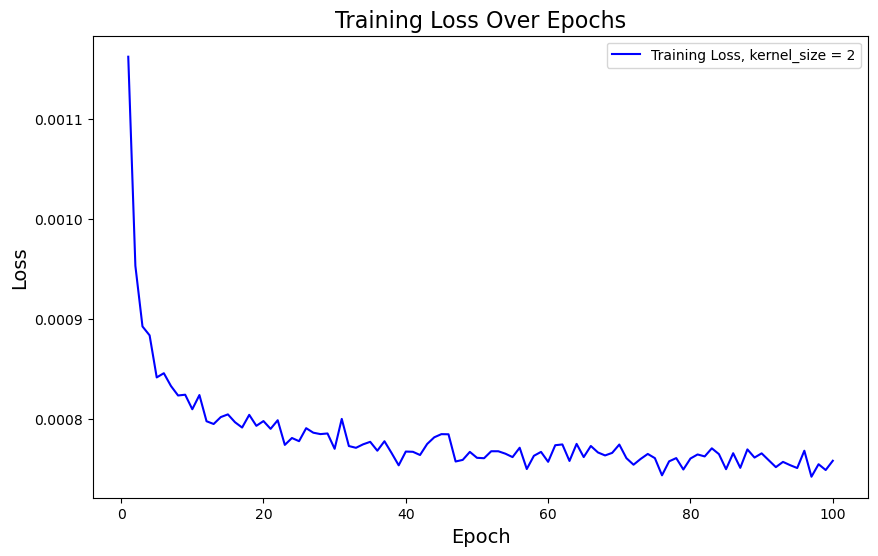

Epoch 1/100, Loss: 0.0014839624870778517, for snr_value = 1, for kenerl size = 3
Epoch 2/100, Loss: 0.0009985790641033364, for snr_value = 1, for kenerl size = 3
Epoch 3/100, Loss: 0.0009155331893399468, for snr_value = 1, for kenerl size = 3
Epoch 4/100, Loss: 0.000889426230523717, for snr_value = 1, for kenerl size = 3
Epoch 5/100, Loss: 0.000871250248832546, for snr_value = 1, for kenerl size = 3
Epoch 6/100, Loss: 0.0008570020685974491, for snr_value = 1, for kenerl size = 3
Epoch 7/100, Loss: 0.0008371360584301417, for snr_value = 1, for kenerl size = 3
Epoch 8/100, Loss: 0.0008308487052928802, for snr_value = 1, for kenerl size = 3
Epoch 9/100, Loss: 0.0008239494763627448, for snr_value = 1, for kenerl size = 3
Epoch 10/100, Loss: 0.0008284060892822477, for snr_value = 1, for kenerl size = 3
Epoch 11/100, Loss: 0.0008161309791224388, for snr_value = 1, for kenerl size = 3
Epoch 12/100, Loss: 0.0008079284016989108, for snr_value = 1, for kenerl size = 3
Epoch 13/100, Loss: 0.00081

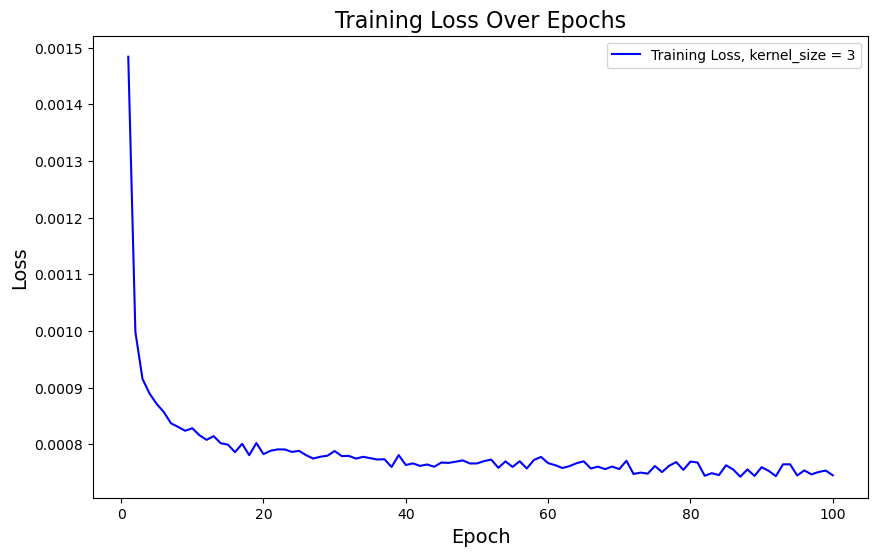

Epoch 1/100, Loss: 0.001441756696508759, for snr_value = 1, for kenerl size = 4
Epoch 2/100, Loss: 0.0008715497059907362, for snr_value = 1, for kenerl size = 4
Epoch 3/100, Loss: 0.0008307332904865582, for snr_value = 1, for kenerl size = 4
Epoch 4/100, Loss: 0.0007850283333990613, for snr_value = 1, for kenerl size = 4
Epoch 5/100, Loss: 0.0007724562252120699, for snr_value = 1, for kenerl size = 4
Epoch 6/100, Loss: 0.0007383975405936522, for snr_value = 1, for kenerl size = 4
Epoch 7/100, Loss: 0.0007547407369523117, for snr_value = 1, for kenerl size = 4
Epoch 8/100, Loss: 0.0007531057390402638, for snr_value = 1, for kenerl size = 4
Epoch 9/100, Loss: 0.0007535444077374824, for snr_value = 1, for kenerl size = 4
Epoch 10/100, Loss: 0.0007290929278693226, for snr_value = 1, for kenerl size = 4
Epoch 11/100, Loss: 0.0007332817796279914, for snr_value = 1, for kenerl size = 4
Epoch 12/100, Loss: 0.0007361674090098663, for snr_value = 1, for kenerl size = 4
Epoch 13/100, Loss: 0.0007

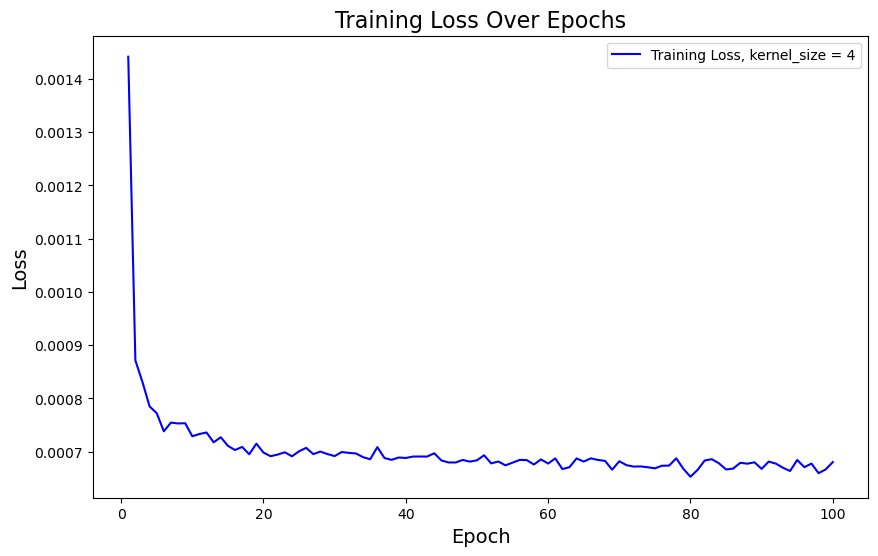

Epoch 1/100, Loss: 0.0011051720513005777, for snr_value = 1, for kenerl size = 5
Epoch 2/100, Loss: 0.0008365662923132928, for snr_value = 1, for kenerl size = 5
Epoch 3/100, Loss: 0.0007867970233229583, for snr_value = 1, for kenerl size = 5
Epoch 4/100, Loss: 0.0007683545235897113, for snr_value = 1, for kenerl size = 5
Epoch 5/100, Loss: 0.0007605417136516075, for snr_value = 1, for kenerl size = 5
Epoch 6/100, Loss: 0.0007553478571935557, for snr_value = 1, for kenerl size = 5
Epoch 7/100, Loss: 0.0007305980489392966, for snr_value = 1, for kenerl size = 5
Epoch 8/100, Loss: 0.0007320734726889379, for snr_value = 1, for kenerl size = 5
Epoch 9/100, Loss: 0.0007394553630386808, for snr_value = 1, for kenerl size = 5
Epoch 10/100, Loss: 0.0007322021106208957, for snr_value = 1, for kenerl size = 5
Epoch 11/100, Loss: 0.0007081070958948283, for snr_value = 1, for kenerl size = 5
Epoch 12/100, Loss: 0.0007181485743072414, for snr_value = 1, for kenerl size = 5
Epoch 13/100, Loss: 0.000

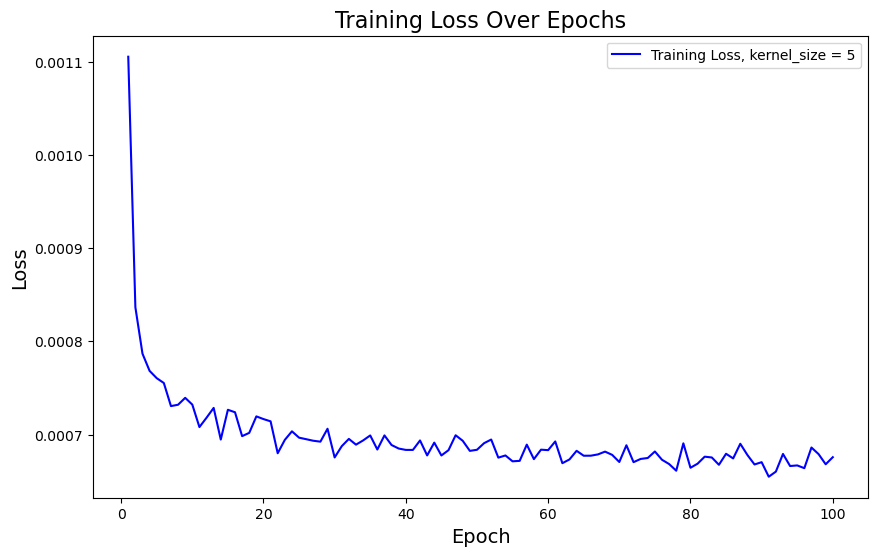

In [8]:
#modeltrain1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device set to : {device}')
kernel_sizes = [2,3,4,5]
snr_values = [1]  # Set the SNR value for testing
performance_metrics = []

for kernel_size in kernel_sizes:
    for snr_value in snr_values:
        model = Autoencoder(kernel_size=kernel_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        num_epochs = 100
        train_loader, valid_loader, test_loader = prepare_denoise_data_scikit(ndat_train=4096, ndat_valid=256, ndat_test=2, test_size=0.2, valid_size=0.25, save_csv=False, directory=os.getcwd(), batch_size=1, plot=False)
        model.train()
        #Generate dataset
        clean_train_loader = DataLoader(train_loader.dataset, batch_size=10, shuffle=True)
        noisy_train_loader = DataLoader(NoisyDataset(train_loader.dataset, snr_value=snr_value), batch_size=10, shuffle=True)

        average_train_loss_per_epoch = []
        for epoch in range(num_epochs):
            total_loss = 0
            for clean_data, noisy_data, _ in noisy_train_loader:
                clean_data, noisy_data = clean_data.to(device), noisy_data.to(device)
                optimizer.zero_grad()
                outputs = model(noisy_data)
                loss = criterion(outputs, clean_data)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            train_loss = total_loss / len(train_loader)
            average_train_loss_per_epoch.append(train_loss)
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, for snr_value = {snr_value}, for kenerl size = {kernel_size}')

        print('Training for kernel size = {kernel_size} is complete') 
        print('model evaluation for kernel size  = {kernel_size}') 
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, num_epochs + 1), average_train_loss_per_epoch, label=f'Training Loss, kernel_size = {kernel_size}', color='blue')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.title('Training Loss Over Epochs', fontsize=16)
        plt.legend()
        plt.show()

        
        model.eval()
        total_mse = 0
        with torch.no_grad():
            noisy_test_loader = DataLoader(NoisyDataset(test_loader.dataset, snr_value=snr_value), batch_size=1, shuffle=False)
            for clean_data, noisy_data, _ in noisy_test_loader:
                clean_data, noisy_data = clean_data.to(device), noisy_data.to(device)
                denoised_output = model(noisy_data)
                total_mse += criterion(denoised_output, clean_data).item()


        average_mse = total_mse / len(noisy_test_loader)  # Use noisy_test_loader for length
        performance_metrics.append(average_mse)

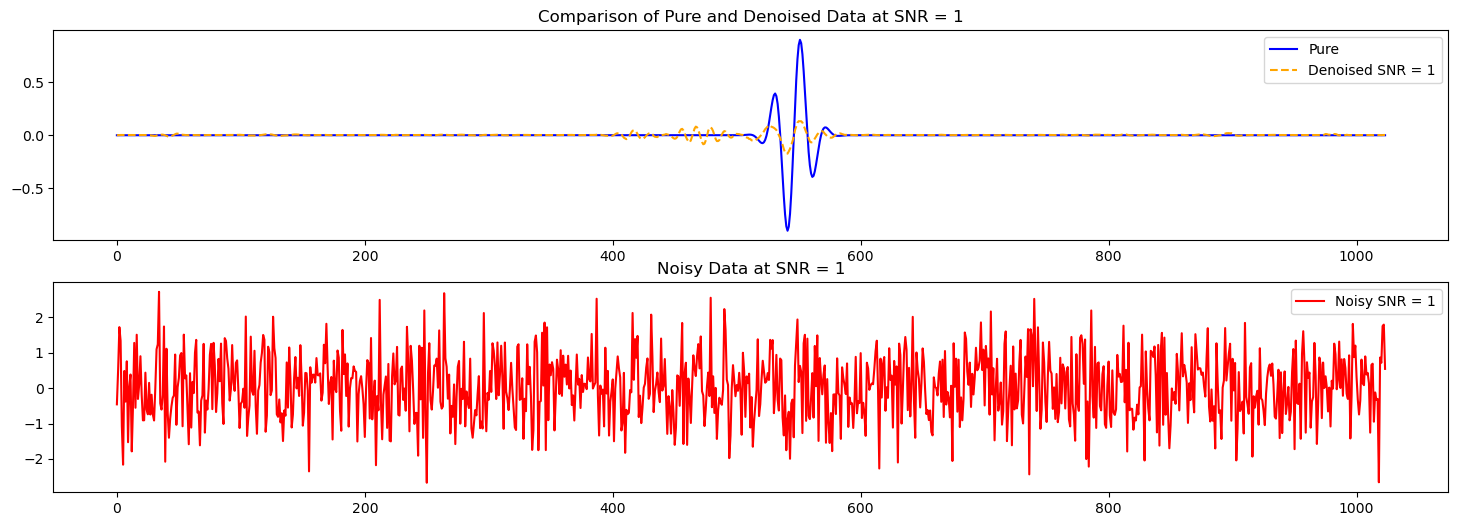

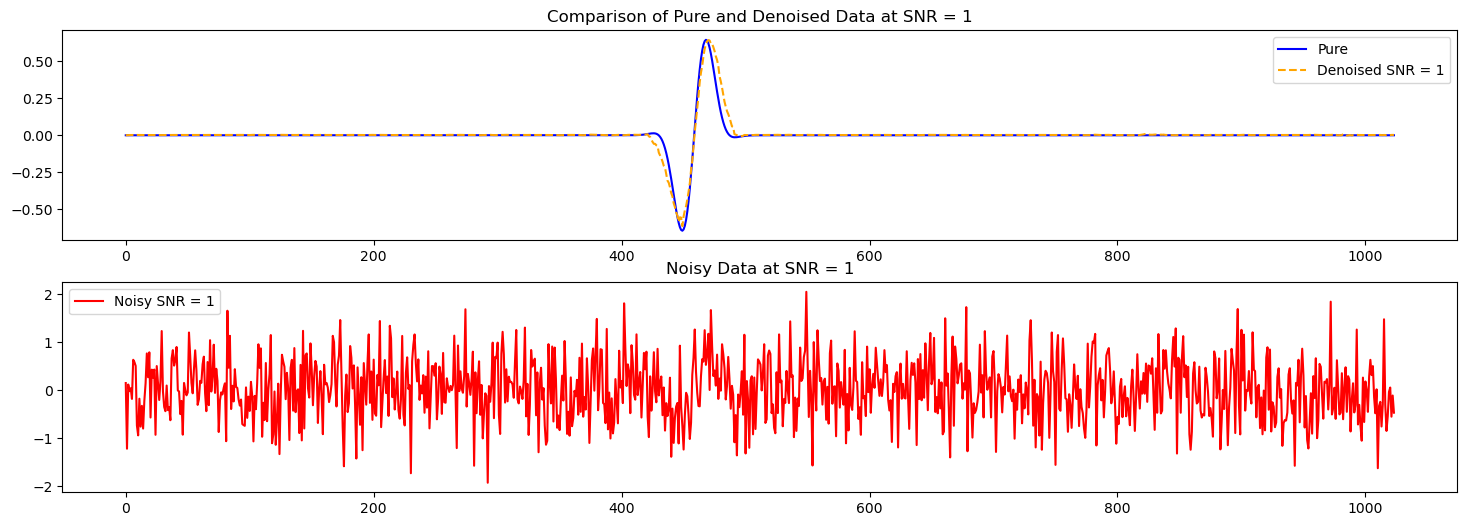

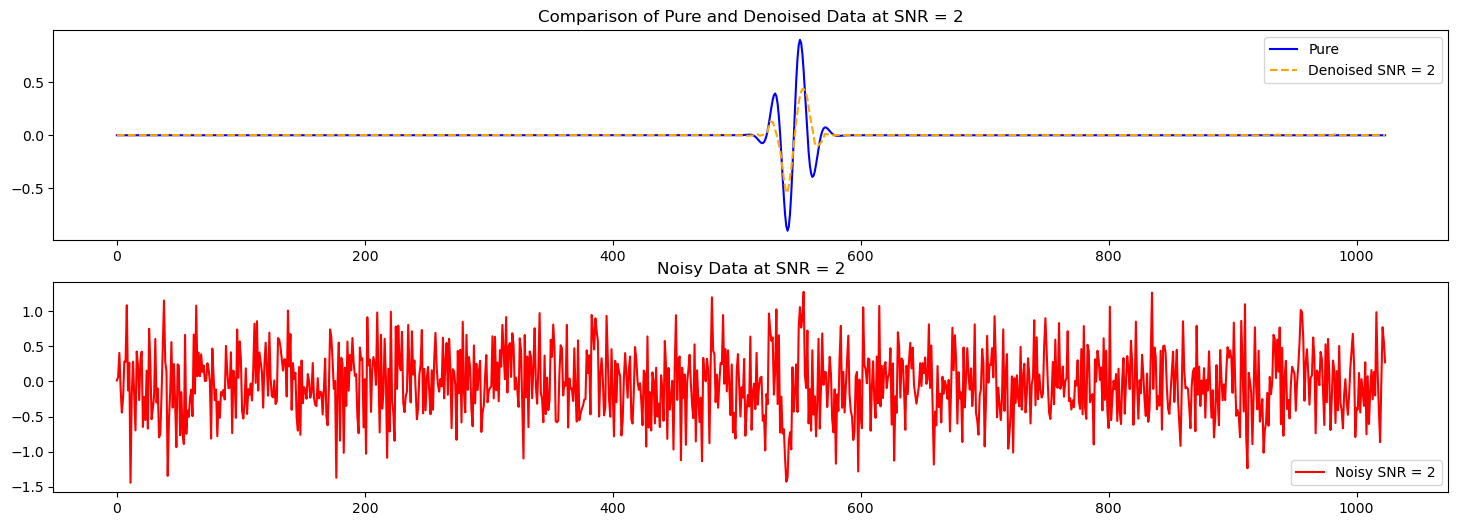

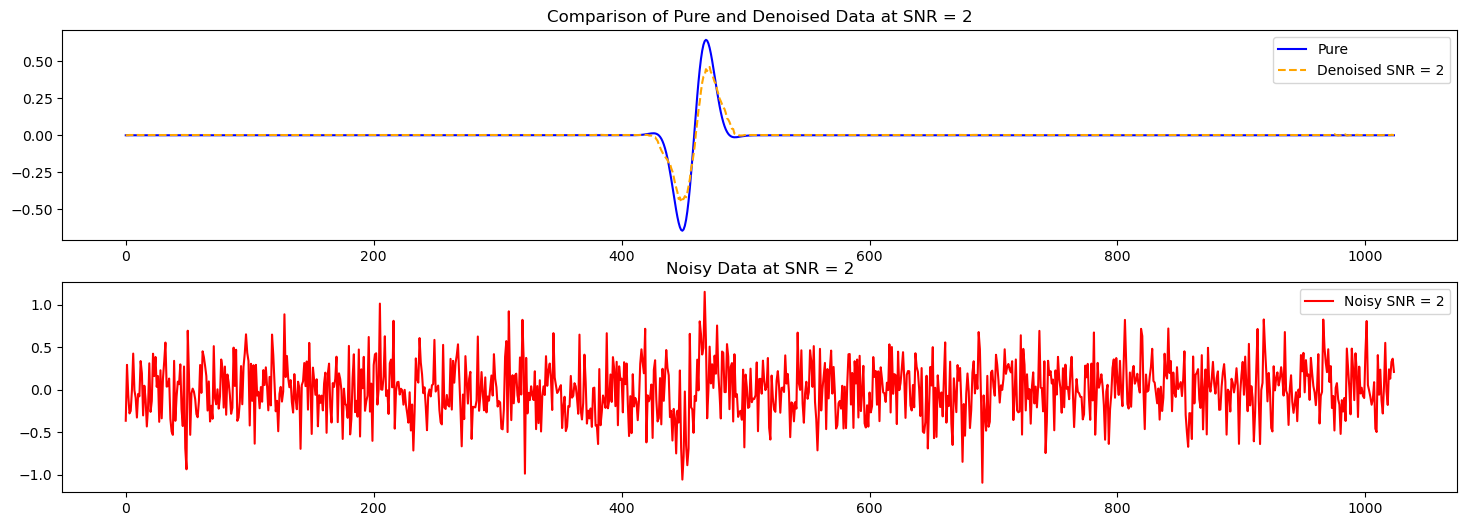

In [16]:
snr_values = [1,2]
model.eval()
with torch.no_grad():
    for snr_value in snr_values:
        noisy_test_loader = DataLoader(NoisyDataset(test_loader.dataset, snr_value=snr_value), batch_size=1, shuffle=False)
        for clean_data, noisy_data, _ in noisy_test_loader:
            clean_data, noisy_data, = clean_data.to(device), noisy_data.to(device)
            denoised_output = model(noisy_data)

            plt.figure(figsize=(18, 6))
            
            # Subplot for Pure and Denoised data
            plt.subplot(2, 1, 1)
            plt.plot(clean_data.cpu().squeeze(), label='Pure', color='blue')
            plt.plot(denoised_output.cpu().squeeze(), label=f'Denoised SNR = {snr_value}', linestyle='--', color='orange')
            plt.title(f'Comparison of Pure and Denoised Data at SNR = {snr_value}')
            plt.legend()
            
            # Subplot for Noisy data
            plt.subplot(2, 1, 2)
            plt.plot(noisy_data.cpu().squeeze(), label=f'Noisy SNR = {snr_value}', color='red')
            plt.title(f'Noisy Data at SNR = {snr_value}')
            plt.legend()
            
            
            # plt.tight_layout()
            plt.show()